In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np

In [2]:
# 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq -y fonts-nanum

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126209 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [3]:
# 런타임 재시작 없이 폰트 적용
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

In [4]:
# 설치된 나눔 폰트 경로 찾기
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fm.fontManager.addfont(font_path)  # 폰트 등록
plt.rc('font', family='NanumGothic')  # 기본 폰트 설정

In [5]:
!pip install dask[dataframe]

In [6]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 12.5 MB/s eta 0:00:00


1. 파일 업로드 및 라이브러리 임포트

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.express as px
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.impute import KNNImputer
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/250223 부동산 허위매물 분류/dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/250223 부동산 허위매물 분류/dataset/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/250223 부동산 허위매물 분류/dataset/sample_submission.csv')

In [8]:
print("Train data length:", len(train))
print("Test data length:", len(test))
print("Sample_submission data length:", len(sample_submission))

Train data length: 2452
Test data length: 613
Sample_submission data length: 613


2. EDA

In [ ]:
train.head(5)

ID 매물확인방식          보증금      월세  전용면적  해당층    총층   방향   방수  욕실수  \
0  TRAIN_0000   현장확인  402500000.0  470000   NaN  NaN  15.0   서향  1.0  1.0   
1  TRAIN_0001   현장확인  170500000.0  200000   NaN  3.0   4.0  남동향  2.0  1.0   
2  TRAIN_0002   전화확인  114000000.0  380000   NaN  2.0   3.0   동향  1.0  1.0   
3  TRAIN_0003   현장확인  163500000.0   30000  36.3  3.0   9.0  남동향  2.0  1.0   
4  TRAIN_0004   현장확인  346000000.0  530000   NaN  3.0   3.0   동향  2.0  1.0   

  주차가능여부  총주차대수  관리비       중개사무소 제공플랫폼         게재일  허위매물여부  
0     가능   40.0   96  t93Nt6I2I0  B플랫폼  2024-10-09       0  
1    불가능    NaN    0  q39iV5J4E6  D플랫폼  2024-12-26       0  
2    불가능    NaN    0  b03oE4G3F6  A플랫폼  2024-11-28       0  
3     가능   13.0   10  G52Iz8V2B9  A플랫폼  2024-11-26       0  
4    불가능    NaN    0  N45gM0M7R0  B플랫폼  2024-06-25       1

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      2452 non-null   object 
 1   매물확인방식  2452 non-null   object 
 2   보증금     2452 non-null   float64
 3   월세      2452 non-null   int64  
 4   전용면적    1665 non-null   float64
 5   해당층     2223 non-null   float64
 6   총층      2436 non-null   float64
 7   방향      2452 non-null   object 
 8   방수      2436 non-null   float64
 9   욕실수     2434 non-null   float64
 10  주차가능여부  2452 non-null   object 
 11  총주차대수   1756 non-null   float64
 12  관리비     2452 non-null   int64  
 13  중개사무소   2452 non-null   object 
 14  제공플랫폼   2452 non-null   object 
 15  게재일     2452 non-null   object 
 16  허위매물여부  2452 non-null   int64  
dtypes: float64(7), int64(3), object(7)
memory usage: 325.8+ KB


In [ ]:
col_to_count = ['매물확인방식', '방향', '중개사무소', '제공플랫폼']
for col in col_to_count:
  print(train[col].value_counts())

매물확인방식
현장확인    1705
전화확인     382
서류확인     365
Name: count, dtype: int64
방향
남향     610
동향     605
서향     389
남동향    275
남서향    220
북향     198
북서향     80
북동향     75
Name: count, dtype: int64
중개사무소
G52Iz8V2B9    799
r82ax9M3U3     43
J52gJ2E4T6     32
H90uE4C0W5     30
b87Td0W4Y3     27
             ... 
c42uU9H5K7      1
z78FX7A1I1      1
G85Og3G9E9      1
V71Gz2X2C5      1
L27JO3N6S2      1
Name: count, Length: 279, dtype: int64
제공플랫폼
A플랫폼    958
B플랫폼    610
C플랫폼    350
D플랫폼    184
E플랫폼    142
F플랫폼     63
G플랫폼     59
H플랫폼     34
I플랫폼     20
J플랫폼     12
L플랫폼     10
K플랫폼      8
M플랫폼      2
Name: count, dtype: int64


# -> 결측치를 확인해본 결과, 해당층, 총층, 전용면적, 방수, 욕실수, 총주차대수에서 결측치가 관찰됨.

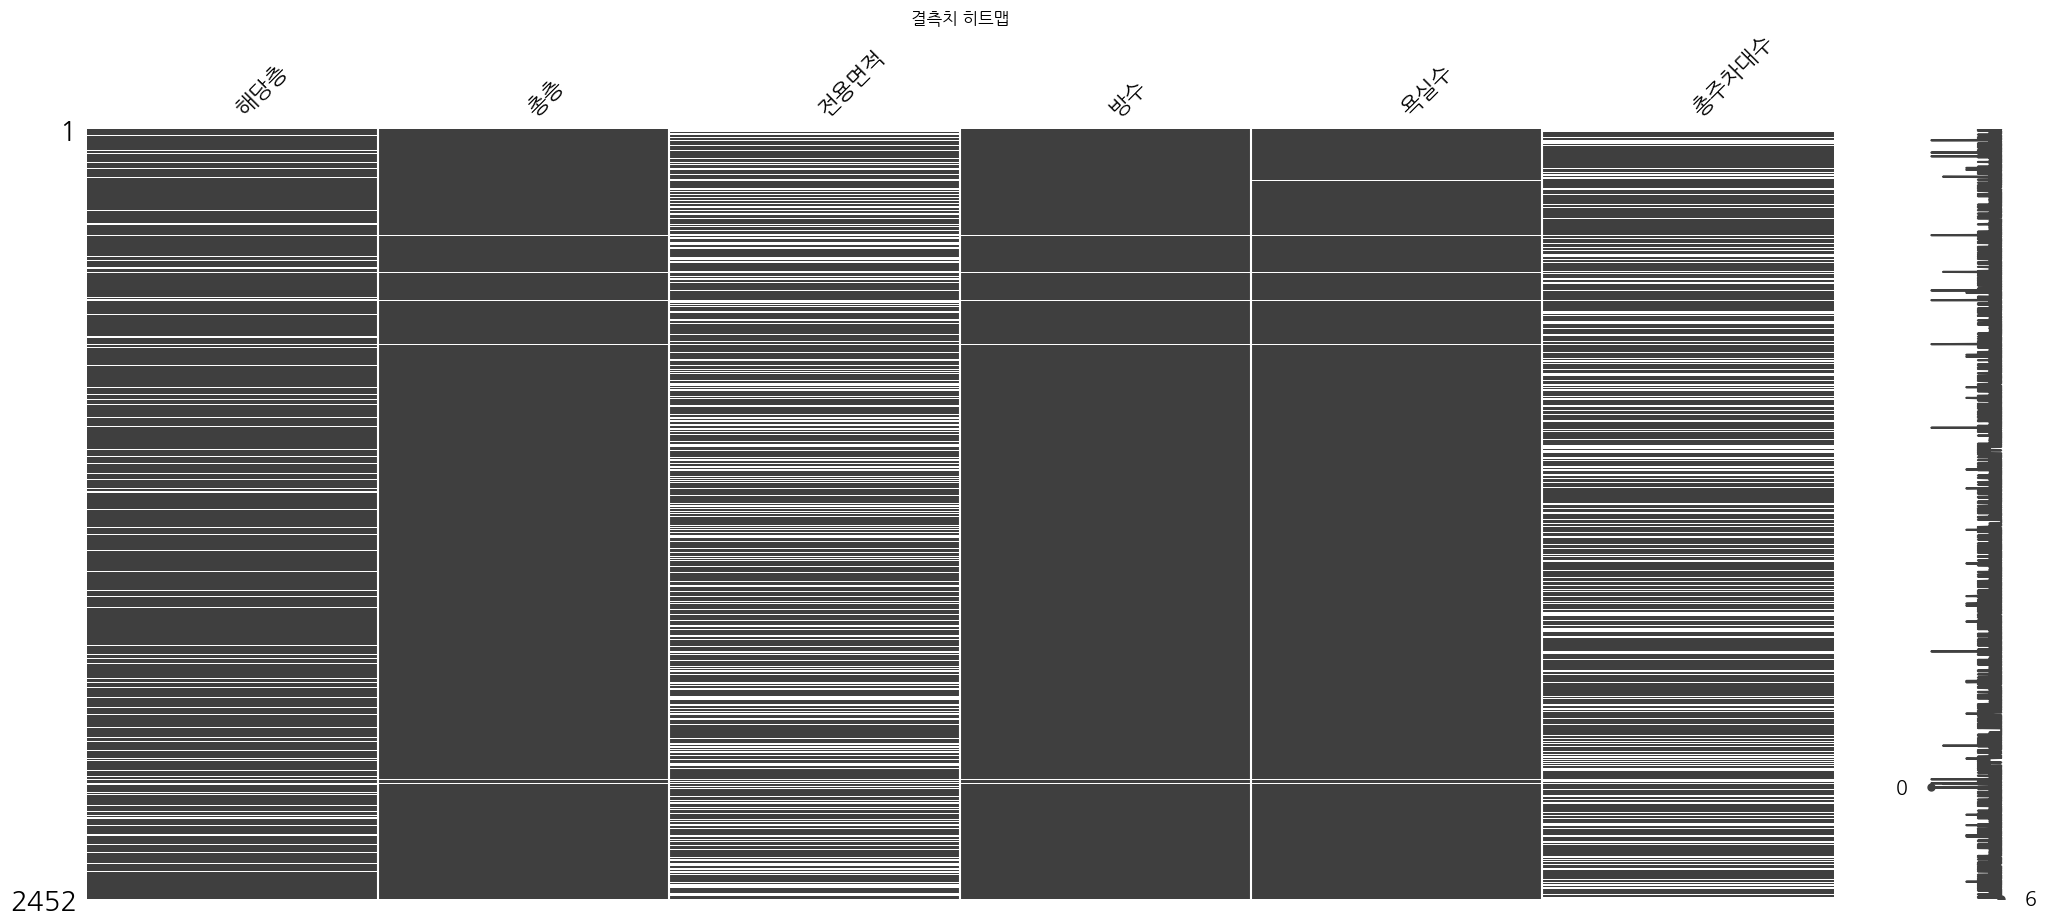

해당층      229
총층        16
전용면적     787
방수        16
욕실수       18
총주차대수    696
dtype: int64


In [ ]:
import missingno as msno
msno.matrix(train[['해당층', '총층', '전용면적', '방수', '욕실수', '총주차대수']])
plt.title('결측치 히트맵')
plt.show()

print(train[['해당층', '총층', '전용면적', '방수', '욕실수', '총주차대수']].isnull().sum())

# -> 결측치 규칙성 없음

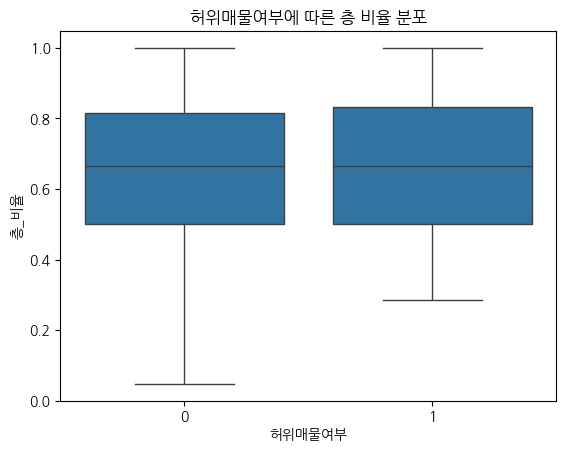

In [ ]:
train['층_비율'] = train['해당층'] / (train['총층'] + 1e-5)
sns.boxplot(data=train, x='허위매물여부', y='층_비율')
plt.title('허위매물여부에 따른 층 비율 분포')
plt.show()

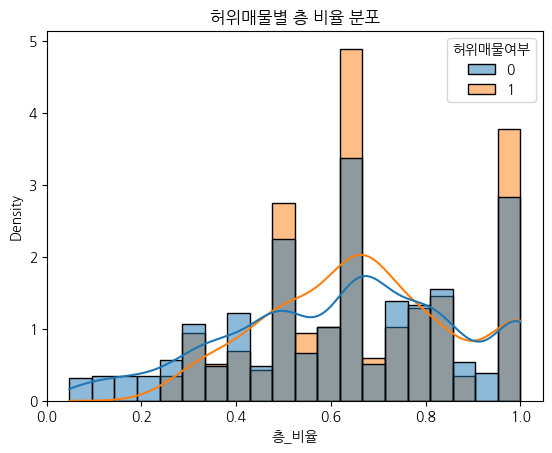

In [ ]:
sns.histplot(data=train, x='층_비율', hue='허위매물여부', kde=True, stat="density", common_norm=False)
plt.title('허위매물별 층 비율 분포')
plt.show()

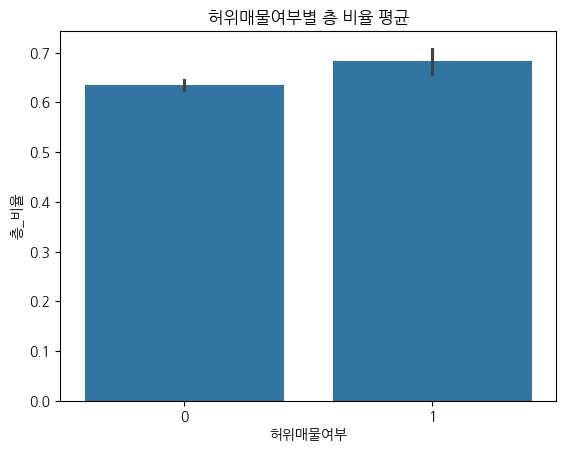

In [ ]:
# 허위/정상 그룹별 층 비율 평균
sns.barplot(x='허위매물여부', y='층_비율', data=train)
plt.title('허위매물여부별 층 비율 평균')
plt.show()

-> 허위매물 그룹에서 상대적으로 층 비율이 높은 경향 확인됨

**- 허위매물의 경우 '좁은 공간에 과도한 방/욕실' 패턴이 발견되어 이를 반영한 변수 생성**

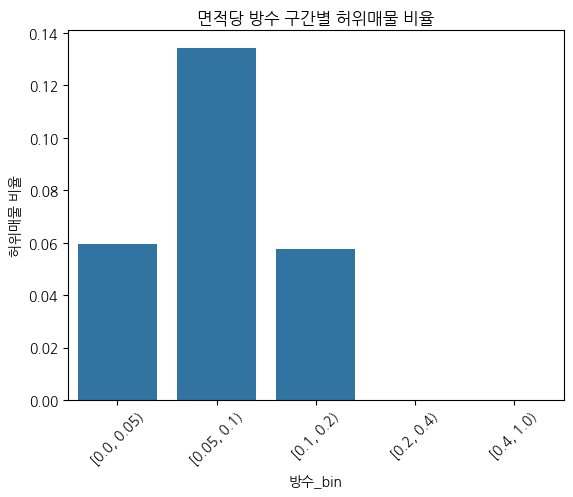

In [ ]:
# 면적당_방수 구간화
train['방수_bin'] = pd.cut(train['면적당_방수'], bins=[0, 0.05, 0.1, 0.2, 0.4, 1.0], right=False)

# 구간별 허위매물 비율 계산
bin_summary = train.groupby('방수_bin')['허위매물여부'].mean().reset_index()

sns.barplot(x='방수_bin', y='허위매물여부', data=bin_summary)
plt.title('면적당 방수 구간별 허위매물 비율')
plt.xticks(rotation=45)
plt.ylabel('허위매물 비율')
plt.show()

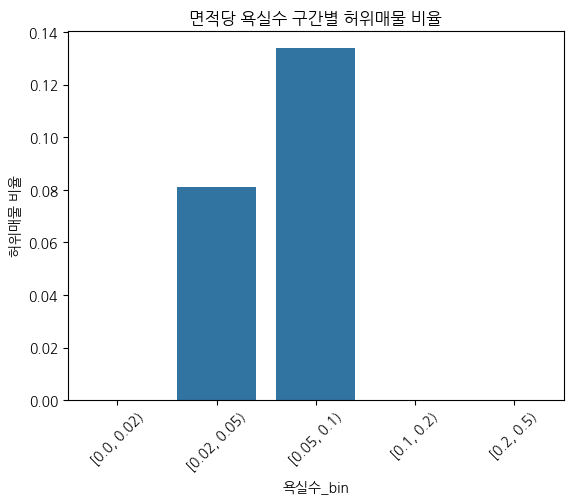

In [ ]:
train['욕실수_bin'] = pd.cut(train['면적당_욕실수'], bins=[0, 0.02, 0.05, 0.1, 0.2, 0.5], right=False)

bin_summary2 = train.groupby('욕실수_bin')['허위매물여부'].mean().reset_index()

sns.barplot(x='욕실수_bin', y='허위매물여부', data=bin_summary2)
plt.title('면적당 욕실수 구간별 허위매물 비율')
plt.xticks(rotation=45)
plt.ylabel('허위매물 비율')
plt.show()

 - 단순 분포로는 패턴을 찾기 어렵다고 판단하여, 비율형 변수를 구간화 후 허위매물 비율을 직접 계산하여 확인

 - 특정 구간(예: 0.1 이상)부터 허위매물 비율이 높아지는 경향이 관찰

In [ ]:
# 면적 대비 방수/욕실수 변수 생성
train['면적당_방수'] = train['방수'] / (train['전용면적'] + 1e-5)
train['면적당_욕실수'] = train['욕실수'] / (train['전용면적'] + 1e-5)

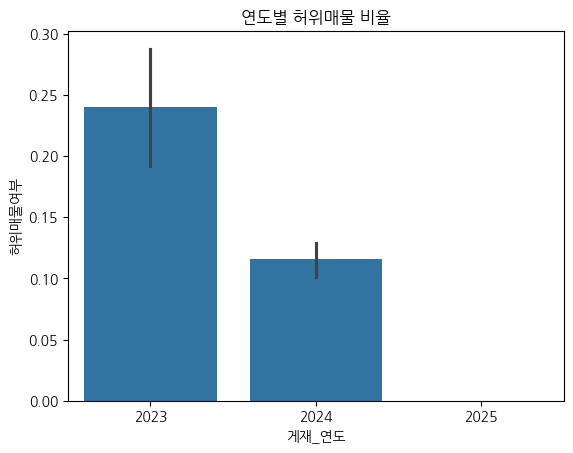

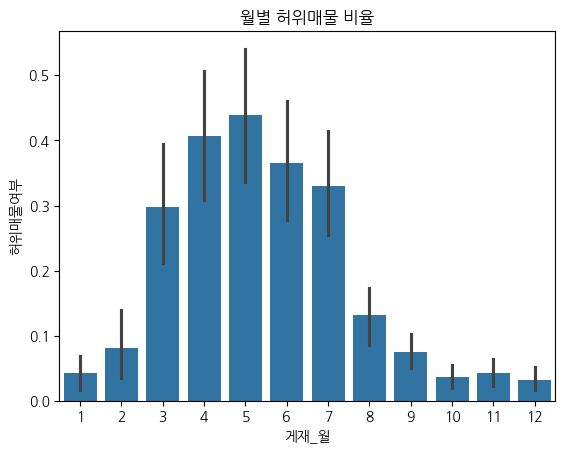

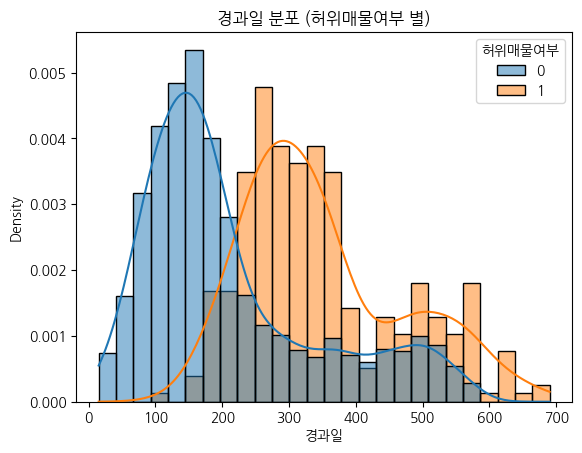

In [ ]:
# 게재일 → 연도/월/일 추출
train['게재일'] = pd.to_datetime(train['게재일'])
train['게재_연도'] = train['게재일'].dt.year
train['게재_월'] = train['게재일'].dt.month

# 연도별 허위매물 비율
sns.barplot(x='게재_연도', y='허위매물여부', data=train)
plt.title('연도별 허위매물 비율')
plt.show()

# 월별 허위매물 비율
sns.barplot(x='게재_월', y='허위매물여부', data=train)
plt.title('월별 허위매물 비율')
plt.show()

# 추가: 실제 경과일의 분포
today = pd.to_datetime('today')
train['경과일'] = (today - train['게재일']).dt.days

sns.histplot(data=train, x='경과일', hue='허위매물여부', kde=True, stat="density", common_norm=False)
plt.title('경과일 분포 (허위매물여부 별)')
plt.show()

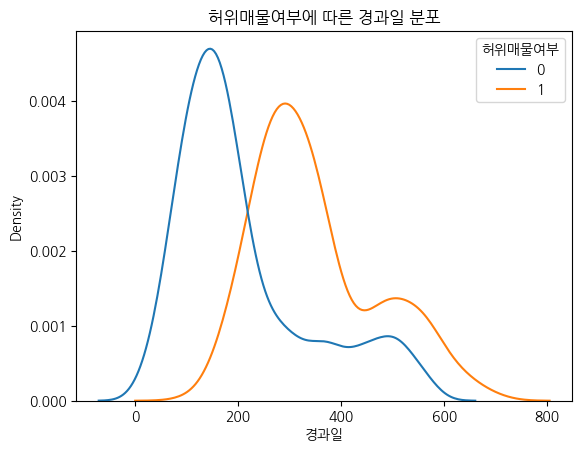

In [ ]:
train['게재일'] = pd.to_datetime(train['게재일'])
today = pd.to_datetime('today')
train['경과일'] = (today - train['게재일']).dt.days

sns.kdeplot(data=train, x='경과일', hue='허위매물여부', common_norm=False)
plt.title('허위매물여부에 따른 경과일 분포')
plt.show()

-> 경과일이 오래된 매물에서 허위매물 비율이 다소 높게 나타남(연도 월 대비 규칙성 뚜렷)

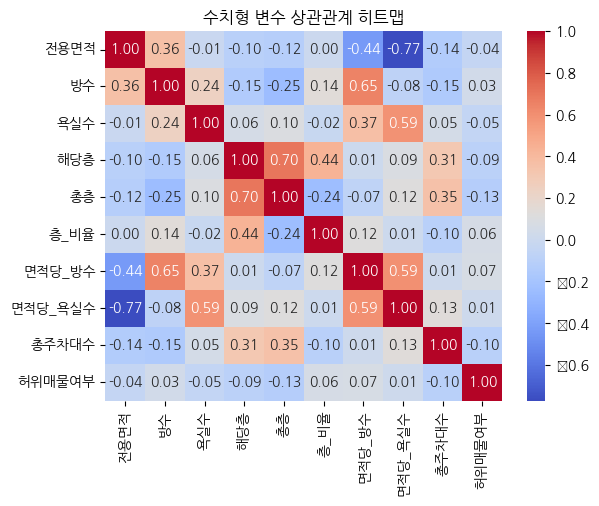

In [ ]:
# 상관관계 히트맵
corr_cols = ['전용면적', '방수', '욕실수', '해당층', '총층',
             '층_비율', '면적당_방수', '면적당_욕실수', '총주차대수', '허위매물여부']

sns.heatmap(train[corr_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('수치형 변수 상관관계 히트맵')
plt.show()

 - 실제 허위매물 여부를 설명하는데 더 직관적이고 해석 가능한 층_비율, 면적당_방수, 면적당_욕실수 파생변수를 채택
 - 단순 수치형 변수(전용면적, 총층)보다 비율형 변수(면적당_방수, 층_비율)가 비정상 패턴을 더 잘 설명

1. 평균/중앙값 대체보다는 KNN Imputer로 주변 이웃의 패턴을 고려해 결측값 채우기
2. 범주형 변수의 경우 분류문제에서 사용 가능한 레이블 인코딩 적용
3. 허위매물일수록 고층 비율 높음
4. 면적대비 방수, 욕실수 특정 구간에서 허위매물 비율 높게 나타남
5. 경과일이 오래된 매물에서 허위매물 비율이 다소 높게 나타남

In [9]:
# 1. KNN 근접치 결측값 채우기 (해당층, 총층, 전용면적, 방수, 욕실수, 총주차대수)
knn_cols = ['해당층', '총층', '전용면적', '방수', '욕실수', '총주차대수']

imputer = KNNImputer(n_neighbors=5)
train[knn_cols] = imputer.fit_transform(train[knn_cols])
test[knn_cols] = imputer.transform(test[knn_cols])

# 2. 라벨 인코딩 (중개사무소, 제공플랫폼, 방향, 매물확인방식)
label_cols = ['중개사무소', '제공플랫폼', '방향', '매물확인방식']
for col in label_cols:
    le = LabelEncoder()
    combined = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(combined)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

# 3. 층 비율 칼럼 추가 (해당층 / 총층)
train['층_비율'] = train['해당층'] / (train['총층'] + 1e-5)
test['층_비율'] = test['해당층'] / (test['총층'] + 1e-5)

# 4. 면적대비 방수, 욕실수 변수 추가
train['면적당_방수'] = train['방수'] / (train['전용면적'] + 1e-5)
train['면적당_욕실수'] = train['욕실수'] / (train['전용면적'] + 1e-5)
test['면적당_방수'] = test['방수'] / (test['전용면적'] + 1e-5)
test['면적당_욕실수'] = test['욕실수'] / (test['전용면적'] + 1e-5)

# 5. 부동산 경과일 변수 추가
train['게재일'] = pd.to_datetime(train['게재일'])
test['게재일'] = pd.to_datetime(test['게재일'])
today = pd.to_datetime('today')
train['경과일'] = (today - train['게재일']).dt.days
test['경과일'] = (today - test['게재일']).dt.days

# 6. 불필요한 컬럼 제거
drop_cols = ['방수', '욕실수', '방향', '주차가능여부', '해당층', '총층', '전용면적', '총주차대수', '게재일']
train.drop(columns=drop_cols, inplace=True, errors='ignore')
test.drop(columns=drop_cols, inplace=True, errors='ignore')

# 최종 확인
print(train.head())
print(test.head())

           ID  매물확인방식          보증금      월세  관리비  중개사무소  제공플랫폼  허위매물여부  \
0  TRAIN_0000       2  402500000.0  470000   96    256      1       0   
1  TRAIN_0001       2  170500000.0  200000    0    240      3       0   
2  TRAIN_0002       1  114000000.0  380000    0    157      0       0   
3  TRAIN_0003       2  163500000.0   30000   10     32      0       0   
4  TRAIN_0004       2  346000000.0  530000    0     76      1       1   

       층_비율    면적당_방수   면적당_욕실수  경과일  
0  0.640000  0.057143  0.057143  163  
1  0.749998  0.054060  0.027030   85  
2  0.666664  0.043825  0.043825  113  
3  0.333333  0.055096  0.027548  115  
4  0.999997  0.048785  0.024393  269  
         ID  매물확인방식          보증금      월세  관리비  중개사무소  제공플랫폼      층_비율  \
0  TEST_000       0  223000000.0  530000    7    151      3  0.999998   
1  TEST_001       0  150500000.0  590000   11     32      3  0.636363   
2  TEST_002       2   47000000.0  200000    0     76      1  0.666664   
3  TEST_003       0  133000000.0  2

In [ ]:
print("Train data length:", len(train))
print("Test data length:", len(test))
print("Sample_submission data length:", len(sample_submission))

Train data length: 2452
Test data length: 613
Sample_submission data length: 613


In [ ]:
train.head()

ID  매물확인방식          보증금      월세  관리비  중개사무소  제공플랫폼  허위매물여부  \
0  TRAIN_0000       2  402500000.0  470000   96    256      1       0   
1  TRAIN_0001       2  170500000.0  200000    0    240      3       0   
2  TRAIN_0002       1  114000000.0  380000    0    157      0       0   
3  TRAIN_0003       2  163500000.0   30000   10     32      0       0   
4  TRAIN_0004       2  346000000.0  530000    0     76      1       1   

       층_비율    면적당_방수   면적당_욕실수  경과일  
0  0.640000  0.057143  0.057143  160  
1  0.749998  0.054060  0.027030   82  
2  0.666664  0.043825  0.043825  110  
3  0.333333  0.055096  0.027548  112  
4  0.999997  0.048785  0.024393  266

In [ ]:
# 컬럼명 확인
print(train.columns)

Index(['ID', '매물확인방식', '보증금', '월세', '관리비', '중개사무소', '제공플랫폼', '허위매물여부', '층_비율',
       '면적당_방수', '면적당_욕실수', '경과일'],
      dtype='object')


In [ ]:
# 컬럼명을 리스트로 변환
print(train.columns.tolist())

['ID', '매물확인방식', '보증금', '월세', '관리비', '중개사무소', '제공플랫폼', '허위매물여부', '층_비율', '면적당_방수', '면적당_욕실수', '경과일']


In [ ]:
columns_to_analyze = ['매물확인방식', '보증금', '월세', '관리비', '중개사무소', '제공플랫폼', '허위매물여부', '층_비율', '면적당_방수', '면적당_욕실수', '경과일']

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


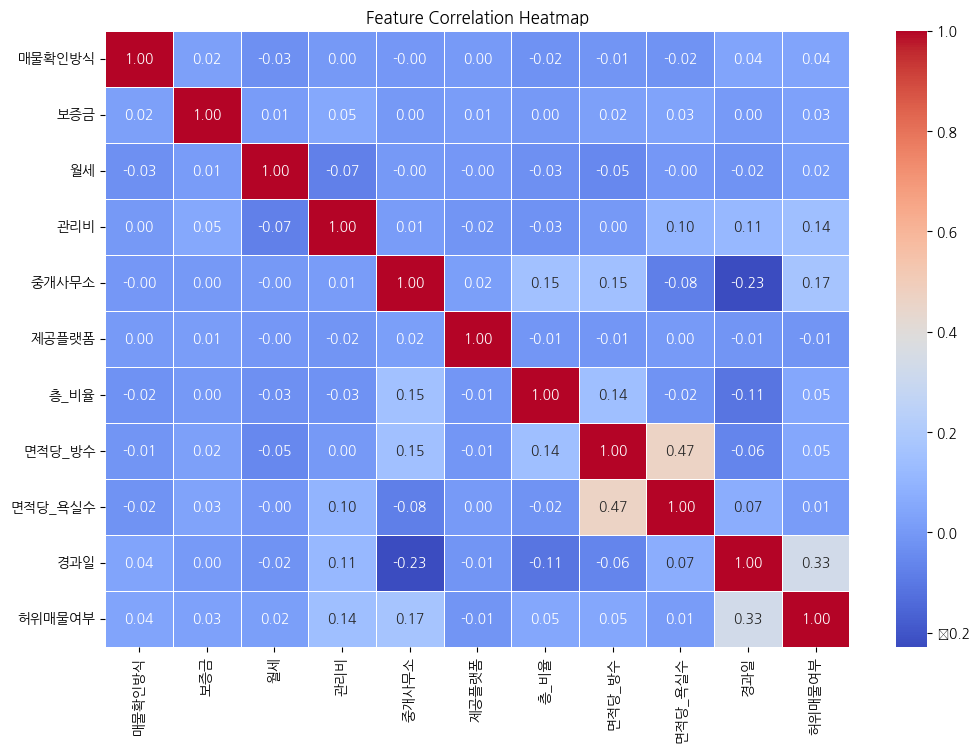

In [ ]:
# 히트맵을 위한 상관행렬 계산
plt.figure(figsize=(12, 8))
sns.heatmap(train[columns_to_analyze].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# **250318 메모**

1. 해당층, 총층, 전용면적, 방수, 욕실수, 총주차대수 KNN 근접치 결측값 채우기
2. 중개사무소, 제공플랫폼, 방향, 매물확인방식 라벨인코딩
3. 층 비율 칼럼 추가
4. 면적대비 방수, 욕실수 변수 추가
5. 부동산 경과일 변수 추가
6. '방수','욕실수','방향','주차가능여부','해당층','총층','전용면적','총주차대수' 칼럼을 제거

# **피쳐 엔지니어링**

In [ ]:
# 컬럼명을 리스트로 변환
print(train.columns.tolist())

['ID', '매물확인방식', '보증금', '월세', '관리비', '중개사무소', '제공플랫폼', '허위매물여부', '층_비율', '면적당_방수', '면적당_욕실수', '경과일']


In [10]:
keep_cols = ['매물확인방식', '보증금', '월세', '관리비', '중개사무소', '제공플랫폼', '허위매물여부', '층_비율', '면적당_방수', '면적당_욕실수', '경과일']

train = train[keep_cols]

In [11]:
keep_cols_test = ['매물확인방식', '보증금', '월세', '관리비', '중개사무소', '제공플랫폼', '층_비율', '면적당_방수', '면적당_욕실수', '경과일']

test = test[keep_cols_test]

In [ ]:
print(len(test), len(sample_submission))

613 613


3. Modeling

In [12]:
# 0. 데이터 준비
X = train.drop(columns=['허위매물여부'])
y = train['허위매물여부']

In [13]:
# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test)

In [14]:
# 1. SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [16]:
# 2. Optuna 하이퍼파라미터 튜닝
# 1) LGBM 하이퍼 파라미터 튜닝 값
def objective_lgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = lgb.LGBMClassifier(**param, random_state=42)
    score = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='f1').mean()
    return score

In [17]:
# 2) XGB 하이퍼 파라미터 튜닝 값
def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
    }
    model = xgb.XGBClassifier(**param, random_state=42, use_label_encoder=False, eval_metric='logloss')
    score = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='f1').mean()
    return score

In [18]:
# 3) RFC 하이퍼 파라미터 튜닝 값

def objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    model = RandomForestClassifier(**param, random_state=42)
    score = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='f1').mean()
    return score

In [19]:
# LGBM 튜닝
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=30)
print("Best LGB params:", study_lgb.best_params)

[I 2025-03-21 02:22:47,177] A new study created in memory with name: no-name-7cd3567f-5ee8-478b-90ed-572f607a0dcc


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive 

[I 2025-03-21 02:22:48,291] Trial 0 finished with value: 0.9479734032495672 and parameters: {'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.014108671950628298, 'num_leaves': 39, 'min_child_samples': 41, 'subsample': 0.623195529562997, 'colsample_bytree': 0.9413338525006893}. Best is trial 0 with value: 0.9479734032495672.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-21 02:22:54,079] Trial 1 finished with value: 0.9810004080856316 and parameters: {'n_estimators': 384, 'max_depth': 15, 'learning_rate': 0.07096560084367581, 'num_leaves': 142, 'min_child_samples': 56, 'subsample': 0.8111803642298259, 'colsample_bytree': 0.8497210598506777}. Best is trial 1 with value: 0.9810004080856316.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-21 02:22:55,656] Trial 2 finished with value: 0.9794149556436086 and parameters: {'n_estimators': 133, 'max_depth': 15, 'learning_rate': 0.13818580200891065, 'num_leaves': 80, 'min_child_samples': 60, 'subsample': 0.6176484913546406, 'colsample_bytree': 0.9223132397703533}. Best is trial 1 with value: 0.9810004080856316.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-21 02:23:05,895] Trial 3 finished with value: 0.977396789043109 and parameters: {'n_estimators': 380, 'max_depth': 14, 'learning_rate': 0.020251760136127672, 'num_leaves': 126, 'min_child_samples': 21, 'subsample': 0.8211983752812261, 'colsample_bytree': 0.8810058490192186}. Best is trial 1 with value: 0.9810004080856316.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-21 02:23:09,104] Trial 4 finished with value: 0.9791470448661801 and parameters: {'n_estimators': 307, 'max_depth': 10, 'learning_rate': 0.08146772685022562, 'num_leaves': 116, 'min_child_samples': 76, 'subsample': 0.7966361532871404, 'colsample_bytree': 0.7762858604018934}. Best is trial 1 with value: 0.9810004080856316.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-21 02:23:11,725] Trial 5 finished with value: 0.9797665725418611 and parameters: {'n_estimators': 446, 'max_depth': 9, 'learning_rate': 0.1484734683345112, 'num_leaves': 49, 'min_child_samples': 20, 'subsample': 0.5610056921548208, 'colsample_bytree': 0.6365004851694102}. Best is trial 1 with value: 0.9810004080856316.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-21 02:23:14,199] Trial 6 finished with value: 0.9793125780864063 and parameters: {'n_estimators': 451, 'max_depth': 14, 'learning_rate': 0.15220205892770117, 'num_leaves': 36, 'min_child_samples': 36, 'subsample': 0.6044928283124389, 'colsample_bytree': 0.6114264209479356}. Best is trial 1 with value: 0.9810004080856316.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive 

[I 2025-03-21 02:23:15,236] Trial 7 finished with value: 0.9584691204267346 and parameters: {'n_estimators': 129, 'max_depth': 15, 'learning_rate': 0.028608017827871993, 'num_leaves': 30, 'min_child_samples': 71, 'subsample': 0.7861410490599834, 'colsample_bytree': 0.8781165253672552}. Best is trial 1 with value: 0.9810004080856316.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-21 02:23:18,628] Trial 8 finished with value: 0.9806671485642342 and parameters: {'n_estimators': 452, 'max_depth': 8, 'learning_rate': 0.1399603322987, 'num_leaves': 133, 'min_child_samples': 29, 'subsample': 0.6361719798252233, 'colsample_bytree': 0.6015291102681121}. Best is trial 1 with value: 0.9810004080856316.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-21 02:23:23,271] Trial 9 finished with value: 0.9802916290323687 and parameters: {'n_estimators': 491, 'max_depth': 10, 'learning_rate': 0.12492139345081399, 'num_leaves': 40, 'min_child_samples': 60, 'subsample': 0.8280298345604794, 'colsample_bytree': 0.9146569557685783}. Best is trial 1 with value: 0.9810004080856316.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-21 02:23:24,294] Trial 10 finished with value: 0.9758372607119943 and parameters: {'n_estimators': 224, 'max_depth': 5, 'learning_rate': 0.08099951453167065, 'num_leaves': 149, 'min_child_samples': 91, 'subsample': 0.9847779434252513, 'colsample_bytree': 0.748641697312003}. Best is trial 1 with value: 0.9810004080856316.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-21 02:23:26,388] Trial 11 finished with value: 0.9794173237406587 and parameters: {'n_estimators': 357, 'max_depth': 7, 'learning_rate': 0.18420308275023373, 'num_leaves': 148, 'min_child_samples': 41, 'subsample': 0.6907751038327589, 'colsample_bytree': 0.5109517126338554}. Best is trial 1 with value: 0.9810004080856316.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-21 02:23:32,268] Trial 12 finished with value: 0.9793731266946406 and parameters: {'n_estimators': 402, 'max_depth': 12, 'learning_rate': 0.06908622916840505, 'num_leaves': 107, 'min_child_samples': 10, 'subsample': 0.9182122389770762, 'colsample_bytree': 0.7529557862646596}. Best is trial 1 with value: 0.9810004080856316.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-21 02:23:36,067] Trial 13 finished with value: 0.9795733965403428 and parameters: {'n_estimators': 299, 'max_depth': 8, 'learning_rate': 0.10777166401433455, 'num_leaves': 86, 'min_child_samples': 52, 'subsample': 0.7123005297604794, 'colsample_bytree': 0.6529808478228534}. Best is trial 1 with value: 0.9810004080856316.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[I 2025-03-21 02:23:39,188] Trial 14 finished with value: 0.9770206084502439 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.05448841151150413, 'num_leaves': 132, 'min_child_samples': 30, 'subsample': 0.8918510337992493, 'colsample_bytree': 0.509470085449864}. Best is trial 1 with value: 0.9810004080856316.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-21 02:23:41,857] Trial 15 finished with value: 0.9812699860558375 and parameters: {'n_estimators': 321, 'max_depth': 12, 'learning_rate': 0.18106867198339707, 'num_leaves': 91, 'min_child_samples': 49, 'subsample': 0.7073417214573037, 'colsample_bytree': 0.8216129043742791}. Best is trial 15 with value: 0.9812699860558375.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-21 02:23:44,355] Trial 16 finished with value: 0.9826000384600139 and parameters: {'n_estimators': 268, 'max_depth': 13, 'learning_rate': 0.18836932391904915, 'num_leaves': 87, 'min_child_samples': 49, 'subsample': 0.7246938051622108, 'colsample_bytree': 0.8017963081951818}. Best is trial 16 with value: 0.9826000384600139.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-21 02:23:46,538] Trial 17 finished with value: 0.9806433225789304 and parameters: {'n_estimators': 227, 'max_depth': 12, 'learning_rate': 0.19443555487704128, 'num_leaves': 69, 'min_child_samples': 74, 'subsample': 0.5022408535036338, 'colsample_bytree': 0.9919194936714515}. Best is trial 16 with value: 0.9826000384600139.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-21 02:23:50,248] Trial 18 finished with value: 0.9812492519768268 and parameters: {'n_estimators': 246, 'max_depth': 13, 'learning_rate': 0.1663886911665262, 'num_leaves': 99, 'min_child_samples': 50, 'subsample': 0.7173937170338015, 'colsample_bytree': 0.8110757418390003}. Best is trial 16 with value: 0.9826000384600139.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-21 02:23:52,544] Trial 19 finished with value: 0.9782533838522554 and parameters: {'n_estimators': 287, 'max_depth': 12, 'learning_rate': 0.17592431472458092, 'num_leaves': 61, 'min_child_samples': 99, 'subsample': 0.7498263361240514, 'colsample_bytree': 0.6853799935746723}. Best is trial 16 with value: 0.9826000384600139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-21 02:23:54,331] Trial 20 finished with value: 0.979384249451636 and parameters: {'n_estimators': 185, 'max_depth': 13, 'learning_rate': 0.16514752974831365, 'num_leaves': 97, 'min_child_samples': 66, 'subsample': 0.6723084790495489, 'colsample_bytree': 0.7092028544290746}. Best is trial 16 with value: 0.9826000384600139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-21 02:23:56,794] Trial 21 finished with value: 0.9810349670116558 and parameters: {'n_estimators': 254, 'max_depth': 13, 'learning_rate': 0.19633998279091738, 'num_leaves': 98, 'min_child_samples': 47, 'subsample': 0.7330840947040533, 'colsample_bytree': 0.8113567047764043}. Best is trial 16 with value: 0.9826000384600139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-21 02:23:59,646] Trial 22 finished with value: 0.9809679134959358 and parameters: {'n_estimators': 334, 'max_depth': 11, 'learning_rate': 0.17361290622065248, 'num_leaves': 82, 'min_child_samples': 48, 'subsample': 0.6677322874816525, 'colsample_bytree': 0.8149395435130601}. Best is trial 16 with value: 0.9826000384600139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[I 2025-03-21 02:24:02,153] Trial 23 finished with value: 0.9798828199243523 and parameters: {'n_estimators': 252, 'max_depth': 13, 'learning_rate': 0.16400649394304284, 'num_leaves': 98, 'min_child_samples': 81, 'subsample': 0.7640609385169692, 'colsample_bytree': 0.815315058474491}. Best is trial 16 with value: 0.9826000384600139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-21 02:24:05,959] Trial 24 finished with value: 0.9782071333773107 and parameters: {'n_estimators': 192, 'max_depth': 11, 'learning_rate': 0.11378344929332046, 'num_leaves': 114, 'min_child_samples': 44, 'subsample': 0.7047067489920502, 'colsample_bytree': 0.7735912126316778}. Best is trial 16 with value: 0.9826000384600139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-21 02:24:08,799] Trial 25 finished with value: 0.9808029804441109 and parameters: {'n_estimators': 330, 'max_depth': 14, 'learning_rate': 0.1862131978703432, 'num_leaves': 68, 'min_child_samples': 62, 'subsample': 0.8461272699566109, 'colsample_bytree': 0.8666032110295848}. Best is trial 16 with value: 0.9826000384600139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-21 02:24:11,174] Trial 26 finished with value: 0.9798324916337201 and parameters: {'n_estimators': 273, 'max_depth': 13, 'learning_rate': 0.1987898299816341, 'num_leaves': 88, 'min_child_samples': 52, 'subsample': 0.5730770018025482, 'colsample_bytree': 0.7241028633713104}. Best is trial 16 with value: 0.9826000384600139.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-21 02:24:13,875] Trial 27 finished with value: 0.9787147413196386 and parameters: {'n_estimators': 190, 'max_depth': 12, 'learning_rate': 0.15355672526642666, 'num_leaves': 73, 'min_child_samples': 34, 'subsample': 0.7457850713951525, 'colsample_bytree': 0.8349701200153731}. Best is trial 16 with value: 0.9826000384600139.


[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2387
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-03-21 02:24:16,549] Trial 28 finished with value: 0.9805880654069835 and parameters: {'n_estimators': 231, 'max_depth': 14, 'learning_rate': 0.12954467796273827, 'num_leaves': 56, 'min_child_samples': 66, 'subsample': 0.6553525362295433, 'colsample_bytree': 0.7868358153258551}. Best is trial 16 with value: 0.9826000384600139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-21 02:24:21,155] Trial 29 finished with value: 0.9801331339620292 and parameters: {'n_estimators': 319, 'max_depth': 11, 'learning_rate': 0.1699140113802796, 'num_leaves': 107, 'min_child_samples': 39, 'subsample': 0.7203437776463181, 'colsample_bytree': 0.9534292187868617}. Best is trial 16 with value: 0.9826000384600139.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [20]:
# XGB 튜닝
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)
print("Best XGB params:", study_xgb.best_params)

[I 2025-03-21 02:25:56,443] A new study created in memory with name: no-name-586b158b-f80b-4ef1-846e-d65e1a9f72b2
[I 2025-03-21 02:25:57,237] Trial 0 finished with value: 0.9478914746224765 and parameters: {'n_estimators': 300, 'max_depth': 13, 'learning_rate': 0.16109178135434066, 'subsample': 0.7396353161748814, 'colsample_bytree': 0.8791131151159968, 'gamma': 4.462357474394957, 'reg_alpha': 3.2657608397600253, 'reg_lambda': 3.545476311315123}. Best is trial 0 with value: 0.9478914746224765.
[I 2025-03-21 02:26:01,107] Trial 1 finished with value: 0.9670909755046916 and parameters: {'n_estimators': 403, 'max_depth': 9, 'learning_rate': 0.11170636324349648, 'subsample': 0.7194409318788867, 'colsample_bytree': 0.8033049469451912, 'gamma': 1.010758648204591, 'reg_alpha': 1.1672884511063886, 'reg_lambda': 2.208900716600255}. Best is trial 1 with value: 0.9670909755046916.
[I 2025-03-21 02:26:02,858] Trial 2 finished with value: 0.9691827034988931 and parameters: {'n_estimators': 199, 'ma

Best XGB params: {'n_estimators': 442, 'max_depth': 5, 'learning_rate': 0.1360778631175534, 'subsample': 0.8406098056531255, 'colsample_bytree': 0.8397664812072249, 'gamma': 0.028482904682691768, 'reg_alpha': 0.46761297105710087, 'reg_lambda': 2.8727569993718918}


In [21]:
# RFC 튜닝
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)
print("Best RF params:", study_rf.best_params)

[I 2025-03-21 02:27:01,141] A new study created in memory with name: no-name-10e5cf6f-f6da-49c8-a3d3-2765c5007658
[I 2025-03-21 02:27:19,779] Trial 0 finished with value: 0.9384775083834356 and parameters: {'n_estimators': 488, 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9384775083834356.
[I 2025-03-21 02:28:01,342] Trial 1 finished with value: 0.9633025304562521 and parameters: {'n_estimators': 452, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.9633025304562521.
[I 2025-03-21 02:28:17,549] Trial 2 finished with value: 0.9646026433663286 and parameters: {'n_estimators': 160, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 2 with value: 0.9646026433663286.
[I 2025-03-21 02:28:22,165] Trial 3 finished with value: 0.9404604676634267 and parameters: {'n_estimators': 124, 'max_depth': 13, 'min

Best RF params: {'n_estimators': 450, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}


In [22]:
# 3. 모델 정의 (튜닝된 LGBM + XGB + RFC)
lgb_best = lgb.LGBMClassifier(**study_lgb.best_params, random_state=42)
xgb_best = xgb.XGBClassifier(**study_xgb.best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')
rf_best = RandomForestClassifier(**study_rf.best_params, random_state=42)

In [33]:
# 4. 소프트 보팅 앙상블
voting_clf = VotingClassifier(estimators=[
    ('lgb', lgb_best),
    ('xgb', xgb_best),
    ('rf', rf_best)
], voting='soft', n_jobs=-1)

In [35]:
# 5. KFold 교차검증 및 평가지표 확인
kf = KFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
f1_scores = []
roc_auc_scores = []

for train_idx, val_idx in kf.split(X_resampled):
    X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

    voting_clf.fit(X_train, y_train)
    y_pred = voting_clf.predict(X_val)
    y_proba = voting_clf.predict_proba(X_val)[:, 1]

    acc_scores.append(accuracy_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba))

print(f'Accuracy 평균: {np.mean(acc_scores):.4f}')
print(f'F1 평균: {np.mean(f1_scores):.4f}')
print(f'ROC-AUC 평균: {np.mean(roc_auc_scores):.4f}')

Accuracy 평균: 0.9782
F1 평균: 0.9783
ROC-AUC 평균: 0.9957


In [36]:
# 6. 최종 모델 학습 후 테스트 데이터 예측
voting_clf.fit(X_resampled, y_resampled)
test_pred = voting_clf.predict(test_scaled)

5. 제출파일 생성

In [37]:
# 7. 제출파일 생성
sample_submission['허위매물여부'] = test_pred
sample_submission.to_csv('250321_submission_allvoting.csv', index=False, encoding='utf-8-sig')

In [38]:
# 8. 분류 리포트 출력 (SMOTE 후 전체 데이터)
print("\n[Classification Report on Full Train]")
y_full_pred = voting_clf.predict(X_resampled)
print(classification_report(y_resampled, y_full_pred))


[Classification Report on Full Train]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2154
           1       1.00      1.00      1.00      2154

    accuracy                           1.00      4308
   macro avg       1.00      1.00      1.00      4308
weighted avg       1.00      1.00      1.00      4308

